## Word Embeddings for Fun and Profit
### Document classification with Gensim

In this tutorial we'll classify movie plots by genre using word embeddings techniques in [gensim](http://radimrehurek.com/gensim/) . 

See accompanying slides in this repo.

We will show how to get a __'hello-world'__ first untuned run using 7 techniques:

- Bag of words

- Character n-grams

- TF-IDF 

- Averaging word2vec vectors

- doc2vec

- Deep IR 

- Word Mover's Distance

The goal of this tutorial is to show the API so you can start tuning them yourself. Model tuning of the models is out of scope of this tutorial.

We will also compare the accuracy of this first 'no tuning'/out of the box run of these techniques. It is in no way an indication of their best peformance that can be achieved with proper tuning. The benefit of the comparison is to manage the expectations.

## Requirements
- Python 3
- [Google News pre-trained word2vec (1.5 GB)](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
- gensim
- sklearn
- pandas
- matplotlib
- nltk with English stopwords
- pyemd
- 4 GB RAM
- 8 GB disk space for WMD

## Dataset
We will use MovieLens dataset linked with plots from OMDB. Thanks to [Sujit Pal](http://sujitpal.blogspot.de/2016/04/predicting-movie-tags-from-plots-using.html) for this linking idea. The prepared csv is in this repository. If you wish to link the datasets yourself - see the code in the [blog]((http://sujitpal.blogspot.de/2016/04/predicting-movie-tags-from-plots-using.html).

In [43]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords

%matplotlib inline

## Exploring the data



In [42]:
%store -r announcements

In [41]:
pd.read_csv('/home/felix/t2t_data/adhoc/AdHocAnnouncements.csv')

ParserError: Error tokenizing data. C error: Expected 18 fields in line 4, saw 20


In [16]:
%store -r announcements

In [39]:
df

,No,DateTime,IsWeekend,IsBusinessDay,Price,IsPennyStock,HasPriceValue,AbnormalReturn,AbnormalLogRet,ReturnDirection,...,ISIN,dtcreated,date,time,headline,body,title,main,cutoffmain,Firsttopic
0,0,01/05/2004 08:04:01,False,True,15.7800,False,True,-6.581515,-6.808095,Negative,...,DE0005130108,2004-01-05 08:04:01,2004-01-05,08:04:01,FJH AG: Initial assessment of the 2003 annual ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nFJH AG: Initial assessment of the 2003 annua...,\nFJH AG: Initial assessment of the 2003 annua...,38
1,1,01/05/2004 08:14:28,False,True,17.9000,False,True,-0.366029,-0.366698,Negative,...,DE0005865901,2004-01-05 08:14:28,2004-01-05,08:14:28,GRENKELEASING: growth accelerates,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nGRENKELEASING: growth accelerates\n\nBaden-B...,\nGRENKELEASING: growth accelerates\n\nBaden-B...,24
2,3,01/06/2004 08:24:29,False,True,3.5900,False,True,12.568570,11.839235,Positive,...,IL0010845324,2004-01-06 08:24:29,2004-01-06,08:24:29,Valor Announces Largest Sale in Company History,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nUS top-tier electronics manufacturing servic...,\nUS top-tier electronics manufacturing servic...,1
3,4,01/06/2004 14:58:14,False,True,10.2400,False,True,4.630811,4.526793,Positive,...,DE0007454902,2004-01-06 14:58:14,2004-01-06,14:58:14,TELES: Further Stock Repurchase,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,"\nTELES: Further Stock Repurchase\n\nBerlin, J...","\nTELES: Further Stock Repurchase\n\nBerlin, J...",4
4,5,01/06/2004 15:20:53,False,True,25.8800,False,True,-1.917697,-1.936322,Negative,...,DE0006081003,2004-01-06 15:20:53,2004-01-06,15:20:53,Holsten-Brauerei AG,Ad-hoc-announcement processed and transmitted ...,Ad-hoc-announcement processed and transmitted ...,"\nAs on 5 January 2004, HANSA-Brunnen AG - an ...","\nAs on 5 January 2004, HANSA-Brunnen AG - an ...",35
5,6,01/07/2004 07:07:04,False,True,0.0670,True,True,5.741008,5.582264,Positive,...,NL0000233195,2004-01-07 07:07:04,2004-01-07,07:07:04,LYCOS Europe N.V. takes over united-domains AG,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nLYCOS Europe N.V. takes over united-domains ...,\nLYCOS Europe N.V. takes over united-domains ...,22
6,7,01/07/2004 12:35:12,False,True,41.3810,False,True,8.270535,7.946289,Positive,...,DE0006762909,2004-01-07 12:35:12,2004-01-07,12:35:12,november AG is spinning off its diagnostic and...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nnovember AG is spinning off its diagnostic a...,\nnovember AG is spinning off its diagnostic a...,37
7,8,01/08/2004 06:00:48,False,True,5.5600,False,True,1.270251,1.262247,Positive,...,AT0000776307,2004-01-08 06:00:48,2004-01-08,06:00:48,Sanochemia Pharmazeutika AG: Annual Financial ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nAnnual Financial Results 2002/2003 (30.09.20...,\nAnnual Financial Results 2002/2003 (30.09.20...,24
8,9,01/08/2004 07:00:27,False,True,8.0500,False,True,1.135261,1.128870,Positive,...,DE0005493704,2004-01-08 07:00:27,2004-01-08,07:00:27,BOV AG moves from Prime Standard to General St...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nBOV AG moves from Prime Standard to General ...,\nBOV AG moves from Prime Standard to General ...,39
9,10,01/08/2004 07:18:43,False,True,0.0800,True,True,17.631440,16.238612,Positive,...,NL0000233195,2004-01-08 07:18:43,2004-01-08,07:18:43,LYCOS Europe N.V. acquires BuyCentral S.A.S.,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nLYCOS Europe N.V. acquires BuyCentral S.A.S....,\nLYCOS Europe 

In [95]:
df = pd.read_csv('/home/felix/repos/adhoc_13K.csv')
#df = announcements
#df = df.dropna()
df['headline'].apply(lambda x: len(x.split(' '))).sum()

142696

In [96]:
df = df.assign(tag= df.loc[:,'ReturnDirection'])

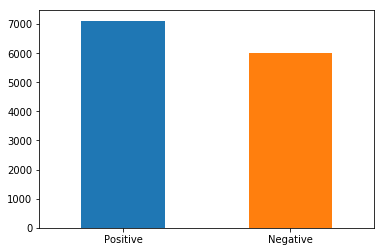

In [97]:
my_tags = ['Positive' , 'Negative']
df.tag.value_counts().plot(kind="bar", rot=0)

The dataset is only __170k__ words. It is quite small but makes sure we don't have to wait a long time for the code to complete.

In [106]:
df.CompanySector[df.CompanySector.notna()].unique()

array(['Software & Computer Services', 'Support Services', 'Beverages',
       'Nonlife Insurance', 'General Industrials',
       'Financial Services (Sector)', 'Technology Hardware & Equipmen',
       'Industrial Engineering', 'Pharmaceuticals & Biotechnolog',
       'Real Estate Investment & Servi', 'Leisure Goods',
       'Health Care Equipment & Servic', 'Food & Drug Retailers',
       'Household Goods & Home Constru', 'Electronic & Electrical Equipm',
       'Media', 'Personal Goods', 'Banks', 'Automobiles & Parts',
       'Travel & Leisure', 'Alternative Energy',
       'Construction & Materials', 'General Retailers', 'Chemicals',
       'Food Producers', 'Mobile Telecommunications', 'Life Insurance',
       'Industrial Transportation', 'Real Estate Investment Trusts',
       'Electricity', 'Industrial Metals & Mining', 'Aerospace & Defense',
       'Forestry & Paper', 'Mining'], dtype=object)

In [107]:
train_data.ReturnDirection

262      Negative
4598     Positive
5208     Negative
11157    Negative
7032     Positive
8669     Positive
1649     Negative
71       Negative
1295     Negative
5453     Negative
10904    Negative
9470     Positive
1613     Negative
6693     Positive
10129    Negative
3928     Positive
10757    Positive
10379    Positive
6755     Positive
7875     Positive
11759    Negative
4576     Negative
2276     Positive
174      Positive
2242     Positive
10029    Negative
11318    Positive
9657     Positive
2496     Positive
9940     Negative
           ...   
9802     Negative
7681     Negative
2176     Positive
8724     Positive
8517     Negative
1639     Positive
5893     Positive
7116     Negative
5876     Positive
8506     Positive
9722     Positive
1096     Positive
9950     Positive
11306    Negative
6720     Positive
5543     Negative
2414     Negative
4306     Positive
6233     Negative
632      Positive
8367     Negative
3379     Negative
9249     Negative
8343     Positive
8562     P

In [71]:
df.ReturnDirection.value_counts()

Positive    7116
Negative    6019
Name: ReturnDirection, dtype: int64

The data is very unbalanced. We have Comedy as majority class. 

A naive classifier that predicts everything to be comedy already achieves __40%__ accuracy.

The language in sci-fi plots differs a lot from action plots, so there should be some signal here.

In [72]:
df


,No,DateTime,IsWeekend,IsBusinessDay,Price,IsPennyStock,HasPriceValue,AbnormalReturn,AbnormalLogRet,ReturnDirection,...,dtcreated,date,time,headline,body,title,main,cutoffmain,Firsttopic,tag
0,0,01/05/2004 08:04:01,False,True,15.7800,False,True,-6.581515,-6.808095,Negative,...,2004-01-05 08:04:01,2004-01-05,08:04:01,FJH AG: Initial assessment of the 2003 annual ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nFJH AG: Initial assessment of the 2003 annua...,\nFJH AG: Initial assessment of the 2003 annua...,38,Negative
1,1,01/05/2004 08:14:28,False,True,17.9000,False,True,-0.366029,-0.366698,Negative,...,2004-01-05 08:14:28,2004-01-05,08:14:28,GRENKELEASING: growth accelerates,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nGRENKELEASING: growth accelerates\n\nBaden-B...,\nGRENKELEASING: growth accelerates\n\nBaden-B...,24,Negative
2,3,01/06/2004 08:24:29,False,True,3.5900,False,True,12.568570,11.839235,Positive,...,2004-01-06 08:24:29,2004-01-06,08:24:29,Valor Announces Largest Sale in Company History,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nUS top-tier electronics manufacturing servic...,\nUS top-tier electronics manufacturing servic...,1,Positive
3,4,01/06/2004 14:58:14,False,True,10.2400,False,True,4.630811,4.526793,Positive,...,2004-01-06 14:58:14,2004-01-06,14:58:14,TELES: Further Stock Repurchase,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,"\nTELES: Further Stock Repurchase\n\nBerlin, J...","\nTELES: Further Stock Repurchase\n\nBerlin, J...",4,Positive
4,5,01/06/2004 15:20:53,False,True,25.8800,False,True,-1.917697,-1.936322,Negative,...,2004-01-06 15:20:53,2004-01-06,15:20:53,Holsten-Brauerei AG,Ad-hoc-announcement processed and transmitted ...,Ad-hoc-announcement processed and transmitted ...,"\nAs on 5 January 2004, HANSA-Brunnen AG - an ...","\nAs on 5 January 2004, HANSA-Brunnen AG - an ...",35,Negative
5,6,01/07/2004 07:07:04,False,True,0.0670,True,True,5.741008,5.582264,Positive,...,2004-01-07 07:07:04,2004-01-07,07:07:04,LYCOS Europe N.V. takes over united-domains AG,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nLYCOS Europe N.V. takes over united-domains ...,\nLYCOS Europe N.V. takes over united-domains ...,22,Positive
6,7,01/07/2004 12:35:12,False,True,41.3810,False,True,8.270535,7.946289,Positive,...,2004-01-07 12:35:12,2004-01-07,12:35:12,november AG is spinning off its diagnostic and...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nnovember AG is spinning off its diagnostic a...,\nnovember AG is spinning off its diagnostic a...,37,Positive
7,8,01/08/2004 06:00:48,False,True,5.5600,False,True,1.270251,1.262247,Positive,...,2004-01-08 06:00:48,2004-01-08,06:00:48,Sanochemia Pharmazeutika AG: Annual Financial ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nAnnual Financial Results 2002/2003 (30.09.20...,\nAnnual Financial Results 2002/2003 (30.09.20...,24,Positive
8,9,01/08/2004 07:00:27,False,True,8.0500,False,True,1.135261,1.128870,Positive,...,2004-01-08 07:00:27,2004-01-08,07:00:27,BOV AG moves from Prime Standard to General St...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nBOV AG moves from Prime Standard to General ...,\nBOV AG moves from Prime Standard to General ...,39,Positive
9,10,01/08/2004 07:18:43,False,True,0.0800,True,True,17.631440,16.238612,Positive,...,2004-01-08 07:18:43,2004-01-08,07:18:43,LYCOS Europe N.V. acquires BuyCentral S.A.S.,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nLYCOS Europe N.V. acquires BuyCentral S.A.S....,\nLYCOS Europe N.V. acquires BuyCentral S.A.S....,14,Positive


In [58]:
def print_plot(index):
    example = df[df.index == index][['headline', 'tag']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Sentiment:', example[1])

In [59]:
print_plot(12)

Lafarge to invest USD40 million to double the capacity of its Chongqing ...
Sentiment: Positive


In [60]:
print_plot(15)

NÜRNBERGER Kooperation not initiated
Sentiment: Negative


Train/test split of 90/10

In [115]:

import re

def clean_control_chars(string):
    """Removes all control characters such as new line \n, tab t\, etc. from a string."""
    try:
        res = re.sub(r'[\x00-\x1f\x7f-\x9f]', ' ', string)
        return " ".join(res.split())
          
        
    except TypeError:
        
        try:
            return [" ".join(re.sub(r'[\x00-\x1f\x7f-\x9f]', ' ', s).split()) for s in string]
        
        except TypeError:
            try:
                return [clean_control_chars(s) for s in string]
            
            except TypeError:
    
                print("Not a string or iterable of strings!")
            

def clean_trailing_period(string):
    """Removes a trailing period from a string."""
    try:
        res = re.sub("\.$", "", string)
        return " ".join(res.split())
          
        
    except TypeError:
        
        try:
            return [" ".join(re.sub("\.$", "", s).split()) for s in string]
        
        except TypeError:
            try:
                return [clean_trailing_period(s) for s in string]
            except TypeError:

                print("Not a string or iterable of strings!")
            

def clean_percent(string):
    """Replace percentage synomyns from a string."""
    try:
        res = re.sub("per cent","percent", string)
        return " ".join(res.split())
          
        
    except TypeError:
        
        try:
            return [" ".join(re.sub("per cent","percent", s).split()) for s in string]
        
        except TypeError:
            try:
                return [clean_percent(s) for s in string]
            except TypeError:

                print("Not a string or iterable of strings!")
                
clean_sents = clean_control_chars(announcements.cutoffmain)            
clean_sents = clean_trailing_period(clean_sents)
documents = clean_percent(clean_sents)
    

In [116]:
documents

['FJH AG: Initial assessment of the 2003 annual result Shortly after the discontinuation of the investigations carried out by the Department of Public Prosecutions, the Executive Board of the consulting and software company FJH AG, listed in the TecDAX (ISIN DE0005130108), has provided an initial, preliminary assessment of the 2003 financial year. Following the first three successful quarters, the fourth quarter was characterised by special factors so that, on the whole, the annual net income is expected to amount to just under 8 million Euro. The anonymous charge against responsible parties at FJH in October 2003 as well as various press articles published in this connection led to an apparent restraint in regard to the placement of new, or the extension of existing, orders. The discontinuation of the investigations just before Christmas had no effect on the fourth quarter any more. Around half of the loss of sales anticipated for the fourth quarter can be attributed to this fact. In 

In [61]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [74]:
%store -r train_index
%store -r test_index

In [85]:
#df = df.dropna()
train_data, test_data = df.iloc[train_index,:],df.iloc[test_index,:]

In [124]:
announcements.cutoffmain = announcements.cutoffmain.apply(clean_control_chars)
announcements.cutoffmain = announcements.cutoffmain.apply(clean_trailing_period)
announcements.cutoffmain = announcements.cutoffmain.apply(clean_percent)

In [89]:
train_data.ReturnDirection.value_counts()/len(train_data)

Positive    0.544006
Negative    0.455994
Name: ReturnDirection, dtype: float64

In [90]:
test_data.ReturnDirection.value_counts()/len(test_data)

Positive    0.543147
Negative    0.456853
Name: ReturnDirection, dtype: float64

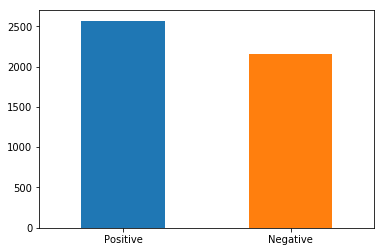

In [81]:
test_data.tag.value_counts().plot(kind="bar", rot=0)

In [65]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [82]:
train_data

,No,DateTime,IsWeekend,IsBusinessDay,Price,IsPennyStock,HasPriceValue,AbnormalReturn,AbnormalLogRet,ReturnDirection,...,dtcreated,date,time,headline,body,title,main,cutoffmain,Firsttopic,tag
262,281,03/12/2004 13:34:14,False,True,358.000,False,True,-1.726816,-1.741901,Negative,...,2004-03-12 13:34:14,2004-03-12,13:34:14,Allianz Lebensversicherungs-AG,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,"\nAllianz Leben increases dividend\nStuttgart,...","\nAllianz Leben increases dividend\nStuttgart,...",34,Negative
4598,5044,02/16/2007 11:15:55,False,True,5.140,False,True,4.925498,4.808040,Positive,...,2007-02-16 11:15:55,2007-02-16,11:15:55,Baader Wertpapierhandelsbank AG: Provisional I...,<pre>\n<b>Baader Wertpapierhandelsbank AG / Fi...,<pre>\n<b>Baader Wertpapierhandelsbank AG / Fi...,\n\nBaader Wertpapierhandelsbank AG:\n\nProvis...,\n\nBaader Wertpapierhandelsbank AG:\n\nProvis...,21,Positive
5208,5724,06/25/2007 06:21:53,False,True,3.356,False,True,-0.187662,-0.187836,Negative,...,2007-06-25 06:21:53,2007-06-25,06:21:53,Beate Uhse AG: Gerard Cok announces his resign...,<pre>\n<b>Beate Uhse AG / Change of Personnel<...,<pre>\n<b>Beate Uhse AG / Change of Personnel<...,\n\nBeate Uhse AG  Gerard Cok announces his r...,\n\nBeate Uhse AG  Gerard Cok announces his r...,7,Negative
11157,12270,05/19/2010 13:26:45,False,True,4.129,False,True,-2.837184,-2.878207,Negative,...,2010-05-19 13:26:45,2010-05-19,13:26:45,Supervisory Board of GoYellow Media AG appoint...,<pre>\n<b>GoYellow Media AG / Change of Perso...,<pre>\n<b>GoYellow Media AG / Change of Perso...,\n\nChristian Mooser to succeed Peter WÃ¼nsch\...,\n\nChristian Mooser to succeed Peter WÃ¼nsch\...,7,Negative
7032,7753,06/12/2008 09:49:29,False,True,22.450,False,True,3.399151,3.342651,Positive,...,2008-06-12 09:49:29,2008-06-12,09:49:29,CeWe commences with share buy-back,<pre>\n<b>CeWe Color Holding AG / Share Buybac...,<pre>\n<b>CeWe Color Holding AG / Share Buybac...,\n\nCeWe commences with share buy-back \n\nO...,\n\nCeWe commences with share buy-back \n\nO...,4,Positive
8669,9562,02/27/2009 23:37:22,False,True,0.628,True,False,3.192673,3.142769,Positive,...,2009-02-27 23:37:22,2009-02-27,23:37:22,PETROTEC AG: IC Green Energy informs about BaF...,<pre>\n<b>PETROTEC AG / Legal Matter/Restructu...,<pre>\n<b>PETROTEC AG / Legal Matter/Restructu...,\n\nAd hoc announcement according to Â§ 15 WpH...,\n\nAd hoc announcement according to Â§ 15 WpH...,13,Positive
1649,1800,02/10/2005 08:30:56,False,True,35.750,False,True,-1.387712,-1.397428,Negative,...,2005-02-10 08:30:56,2005-02-10,08:30:56,DaimlerChrysler AG: Business Development 2004,Ad hoc announcement §15 WpHG\n\nBusiness Devel...,Ad hoc announcement §15 WpHG\n\nBusiness Devel...,---\nDaimlerChrysler achieves an operating pro...,---\nDaimlerChrysler achieves an operating pro...,11,Negative
71,75,01/29/2004 17:05:09,False,True,10.846,False,True,-3.213893,-3.266674,Negative,...,2004-01-29 17:05:09,2004-01-29,17:05:09,The Fantastic Corporation: Negotiations to sav...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,\nNegotiations to save Fantastic have failed\n...,\nNegotiations to save Fantastic have failed\n...,40,Negative
1295,1404,11/11/2004 07:00:31,False,True,13.670,False,True,-11.815890,-12.574344,Negative,...,2004-11-11 07:00:31,2004-11-11,07:00:31,"MEDION AG, ESSEN - German turnover down, forei...",Ad-hoc-announcement transmitted by DGAP.\nThe ...,Ad-hoc-announcement transmitted by DGAP.\nThe ...,"\nMEDION AG, ESSEN - German turnover down, for...","\nMEDION AG, ESSEN - German turnover down, for...",24,Negative
5453,5987,08/10/2007 20:02:09,False,True,11.783,False,False,-3.515067,-3.578330,Negative,...,2007-08-10 20:02:09,2007-08-10,20:02:09,Deutsche REIT AG parts with CFO,<pre>\n<b>Deutsche REIT AG / Change of Personn...,<pre>\n<b>Deutsche REIT AG / Change of Personn...,\n\nThe Supervisory Board of Deutsche REIT AG 

In [92]:
pd.read_csv('/home/felix/repos/companyMeta.csv')

,name,wkn,foundingYear,ticker,industry,sector,country,stocktype,listingDate,exchangeID
0,"0,375% KA Finanz AG 15/20 auf Festzins",XS1270771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,"1,25% NRW Städte 15/22 auf Festzins",DE000A161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2,"10,00% Isar Capital Funding 1 LP 09/15 auf Fes...",A1APTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
3,10tacle Studios,TACL10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,118000,691190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
5,"2,30% IKB Deutsche Industriebank AG 14/17 auf ...",A1X3J1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,"3,875% ATON Group Finance GmbH 13/18 auf Festzins",A1YCQ4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,"360 HOLDING AB SK -,50",SE0001295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
8,3S Industries,A0Q48P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
9,3U Holding,516790,1997.0,UUU,Telekomdienstleister,Telekommunikation,Deutschland,Inlandsaktie,NaN,6


## Model evaluation approach
We will use confusion matrices to evaluate all classifiers

In [66]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [67]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [68]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['headline'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

## Baseline: bag of words, n-grams, tf-idf
Let's start with some simple baselines before diving into more advanced methods.

### Bag of words

The simplest document feature is just a count of each word occurrence in a document.

We remove stop-words and use NLTK tokenizer then limit our vocabulary to 3k most frequent words.

In [69]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [155]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['headline'])
test_data_features = count_vectorizer.transform(test_data['headline'])

CPU times: user 1.21 s, sys: 3.89 ms, total: 1.21 s
Wall time: 1.21 s


Multi-modal logistic regression is a simple white-box classifier. We will use either logistic regression or KNN throughout this tutorial.

In [156]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 1.7 s, sys: 4.15 ms, total: 1.71 s
Wall time: 1.71 s


In [114]:
count_vectorizer.get_feature_names()[80:90]

['2009/10',
 '2009/2010',
 '2010',
 '2010/11',
 '2011',
 '2014',
 '21',
 '22',
 '220',
 '23']

Nothing impressive - only 2% better better than the classifier that thinks that everything is a comedy.

In [93]:
print('Len: {}'.format(len(train_data)))
train_data.tag.value_counts()/len(train_data)


Len: 7090


Positive    0.544006
Negative    0.455994
Name: tag, dtype: float64

In [116]:
print('Len: {}'.format(len(test_data)))
test_data.tag.value_counts()/len(test_data)

Len: 4703


Positive    0.54242
Negative    0.45758
Name: tag, dtype: float64

accuracy 0.5473102275143525
confusion matrix
 [[1074 1078]
 [1051 1500]]
(row=expected, col=predicted)
CPU times: user 591 ms, sys: 13 ms, total: 604 ms
Wall time: 582 ms


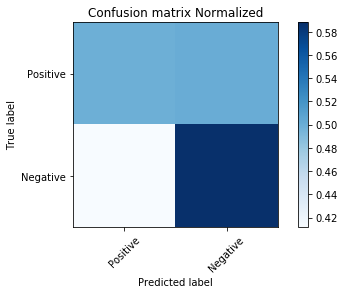

In [157]:
%%time

predict(count_vectorizer, logreg, test_data)

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

Nearest Neighbors accuracy: 0.5332766319370614
accuracy 0.5332766319370614
confusion matrix
 [[ 984 1168]
 [1027 1524]]
(row=expected, col=predicted)
Linear SVM accuracy: 0.5541143950669786
accuracy 0.5541143950669786
confusion matrix
 [[ 863 1289]
 [ 808 1743]]
(row=expected, col=predicted)
RBF SVM accuracy: 0.5702742930044652
accuracy 0.5702742930044652
confusion matrix
 [[ 726 1426]
 [ 595 1956]]
(row=expected, col=predicted)
Random Forest accuracy: 0.5443334042100787
accuracy 0.5443334042100787
confusion matrix
 [[  16 2136]
 [   7 2544]]
(row=expected, col=predicted)
Neural Net accuracy: 0.5424197320859027
accuracy 0.5424197320859027
confusion matrix
 [[   0 2152]
 [   0 2551]]
(row=expected, col=predicted)
AdaBoost accuracy: 0.5517754624707634
accuracy 0.5517754624707634
confusion matrix
 [[ 231 1921]
 [ 187 2364]]
(row=expected, col=predicted)
Naive Bayes accuracy: 0.49436529874548163
accuracy 0.49436529874548163
confusion matrix
 [[1792  360]
 [2018  533]]
(row=expected, col=pr

/home/felix/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA accuracy: 0.5449712949181373
accuracy 0.5449712949181373
confusion matrix
 [[ 276 1876]
 [ 264 2287]]
(row=expected, col=predicted)
Gaussian Process accuracy: 0.5590048904954285
accuracy 0.5590048904954285
confusion matrix
 [[ 520 1632]
 [ 442 2109]]
(row=expected, col=predicted)
Decision Tree accuracy: 0.5551775462470764
accuracy 0.5551775462470764
confusion matrix
 [[1089 1063]
 [1029 1522]]
(row=expected, col=predicted)


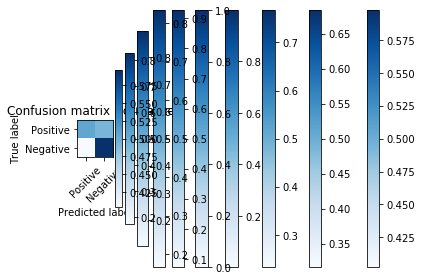

In [189]:
results_bow = baseline_models(train_data_features, train_data['tag'],test_data_features, test_data['tag'])

In [76]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]    

In [77]:
# words for the fantasy genre
genre_tag_id = 0
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

Positive


['trucks',
 'vw',
 'supreme',
 'acquisitions',
 'australian',
 'uefa',
 'awarded',
 'partial',
 'enhances',
 'fuel']

In [78]:
train_data_features[0]

<1x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

### Character N-grams

A character _n-gram_ is a chunk of a document of length _n_. It is a poor man's tokenizer but sometimes works well. The parameter _n_ depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones.

In [177]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char", stop_words='english',
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['headline'])
test_data_features = n_gram_vectorizer.transform(test_data['headline'])

logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 14 s, sys: 16.7 ms, total: 14 s
Wall time: 14 s


accuracy 0.5392302785456092
confusion matrix
 [[1060 1092]
 [1075 1476]]
(row=expected, col=predicted)


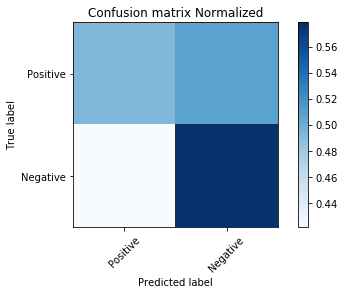

In [178]:
predict(n_gram_vectorizer, logreg, test_data)

Nearest Neighbors accuracy: 0.5426323623219221
accuracy 0.5426323623219221
confusion matrix
 [[1043 1109]
 [1042 1509]]
(row=expected, col=predicted)
Linear SVM accuracy: 0.5515628322347438
accuracy 0.5515628322347438
confusion matrix
 [[1047 1105]
 [1004 1547]]
(row=expected, col=predicted)
RBF SVM accuracy: 0.576227939613013
accuracy 0.576227939613013
confusion matrix
 [[ 198 1954]
 [  39 2512]]
(row=expected, col=predicted)
Random Forest accuracy: 0.5500744205826068
accuracy 0.5500744205826068
confusion matrix
 [[  90 2062]
 [  54 2497]]
(row=expected, col=predicted)
Neural Net accuracy: 0.5441207739740591
accuracy 0.5441207739740591
confusion matrix
 [[1193  959]
 [1185 1366]]
(row=expected, col=predicted)
AdaBoost accuracy: 0.5337018924091006
accuracy 0.5337018924091006
confusion matrix
 [[ 783 1369]
 [ 824 1727]]
(row=expected, col=predicted)
Naive Bayes accuracy: 0.530087178396768
accuracy 0.530087178396768
confusion matrix
 [[1242  910]
 [1300 1251]]
(row=expected, col=predicte

/home/felix/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA accuracy: 0.5696364022964066
accuracy 0.5696364022964066
confusion matrix
 [[ 592 1560]
 [ 464 2087]]
(row=expected, col=predicted)
Gaussian Process accuracy: 0.5585796300233893
accuracy 0.5585796300233893
confusion matrix
 [[ 522 1630]
 [ 446 2105]]
(row=expected, col=predicted)
Decision Tree accuracy: 0.5385923878375505
accuracy 0.5385923878375505
confusion matrix
 [[1060 1092]
 [1078 1473]]
(row=expected, col=predicted)


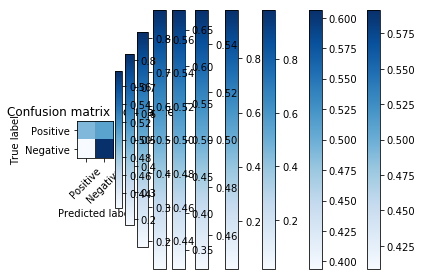

In [179]:
results_ngrams_char = baseline_models(train_data_features, train_data['tag'],test_data_features, test_data['tag'])

In [180]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="word",
    ngram_range=([1,1]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['headline'])
test_data_features = n_gram_vectorizer.transform(test_data['headline'])

logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 2.07 s, sys: 32.8 ms, total: 2.11 s
Wall time: 2.04 s


accuracy 0.5577291090793111
confusion matrix
 [[1095 1057]
 [1023 1528]]
(row=expected, col=predicted)


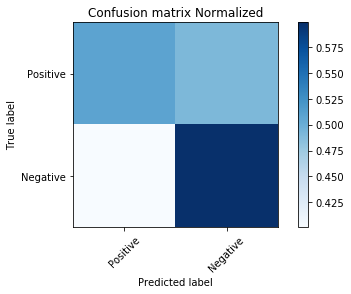

In [181]:
predict(n_gram_vectorizer, logreg, test_data)

Nearest Neighbors accuracy: 0.5171167339995747
accuracy 0.5171167339995747
confusion matrix
 [[1277  875]
 [1396 1155]]
(row=expected, col=predicted)
Linear SVM accuracy: 0.550499681054646
accuracy 0.550499681054646
confusion matrix
 [[1013 1139]
 [ 975 1576]]
(row=expected, col=predicted)
RBF SVM accuracy: 0.5764405698490326
accuracy 0.5764405698490326
confusion matrix
 [[ 206 1946]
 [  46 2505]]
(row=expected, col=predicted)
Random Forest accuracy: 0.5432702530299809
accuracy 0.5432702530299809
confusion matrix
 [[   6 2146]
 [   2 2549]]
(row=expected, col=predicted)
Neural Net accuracy: 0.5628322347437805
accuracy 0.5628322347437805
confusion matrix
 [[ 852 1300]
 [ 756 1795]]
(row=expected, col=predicted)
AdaBoost accuracy: 0.549011269402509
accuracy 0.549011269402509
confusion matrix
 [[ 254 1898]
 [ 223 2328]]
(row=expected, col=predicted)
Naive Bayes accuracy: 0.49308951732936424
accuracy 0.49308951732936424
confusion matrix
 [[1803  349]
 [2035  516]]
(row=expected, col=predic

/home/felix/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA accuracy: 0.5356155645332766
accuracy 0.5356155645332766
confusion matrix
 [[1329  823]
 [1361 1190]]
(row=expected, col=predicted)
Gaussian Process accuracy: 0.5424197320859027
accuracy 0.5424197320859027
confusion matrix
 [[   0 2152]
 [   0 2551]]
(row=expected, col=predicted)
Decision Tree accuracy: 0.5426323623219221
accuracy 0.5426323623219221
confusion matrix
 [[1000 1152]
 [ 999 1552]]
(row=expected, col=predicted)


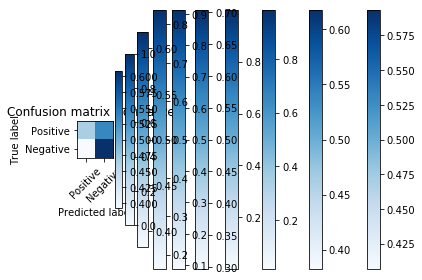

In [182]:
results_ngrams_tf = baseline_models(train_data_features, train_data['tag'],test_data_features, test_data['tag'])

In [183]:
n_gram_vectorizer.get_feature_names()[50:60]

['2020', '21', '22', '220', '23', '24', '25', '26', '266', '27']

The results are worse than using a tokenizer and bag of words. Probably due to not removing the stop words.

### TF-IDF

[Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a little more advanced way to count words in a document.
It adjusts for document length, word frequency and most importantly for frequency of a particular word in a particular document.


In [184]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['headline'])
test_data_features = tf_vect.transform(test_data['headline'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

/home/felix/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


CPU times: user 1.83 s, sys: 4.13 ms, total: 1.83 s
Wall time: 1.83 s


In [185]:
tf_vect.get_feature_names()[1000:1010]

['decides',
 'decision',
 'decisions',
 'declaration',
 'decline',
 'declining',
 'decrease',
 'decreased',
 'decreases',
 'defence']

accuracy 0.5453965553901765
confusion matrix
 [[1080 1072]
 [1066 1485]]
(row=expected, col=predicted)


/home/felix/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


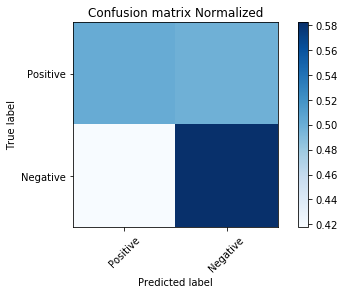

In [186]:
predict(tf_vect, logreg, test_data)

Score without CV and l1 penalty: 0.5424197320859027
accuracy 0.5424197320859027
confusion matrix
 [[ 612 1540]
 [ 612 1939]]
(row=expected, col=predicted)
Score with CV: 0.5560280671911546
accuracy 0.5560280671911546
confusion matrix
 [[ 669 1483]
 [ 605 1946]]
(row=expected, col=predicted)


{'classifier_CV': LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
 'classifier_default': LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)}

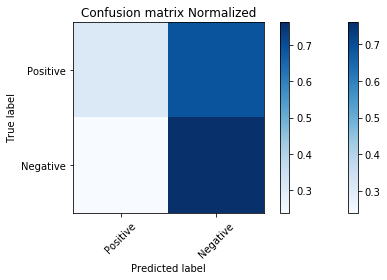

In [187]:
baseline_LogisticRegression(train_data_features, train_data['tag'],test_data_features,test_data.tag,penalty='l1')

Nearest Neighbors accuracy: 0.5322134807569636
accuracy 0.5322134807569636
confusion matrix
 [[ 983 1169]
 [1031 1520]]
(row=expected, col=predicted)
Linear SVM accuracy: 0.5541143950669786
accuracy 0.5541143950669786
confusion matrix
 [[ 863 1289]
 [ 808 1743]]
(row=expected, col=predicted)
RBF SVM accuracy: 0.5702742930044652
accuracy 0.5702742930044652
confusion matrix
 [[ 726 1426]
 [ 595 1956]]
(row=expected, col=predicted)
Random Forest accuracy: 0.5426323623219221
accuracy 0.5426323623219221
confusion matrix
 [[   5 2147]
 [   4 2547]]
(row=expected, col=predicted)
Neural Net accuracy: 0.5424197320859027
accuracy 0.5424197320859027
confusion matrix
 [[   0 2152]
 [   0 2551]]
(row=expected, col=predicted)
AdaBoost accuracy: 0.5517754624707634
accuracy 0.5517754624707634
confusion matrix
 [[ 231 1921]
 [ 187 2364]]
(row=expected, col=predicted)
Naive Bayes accuracy: 0.49436529874548163
accuracy 0.49436529874548163
confusion matrix
 [[1792  360]
 [2018  533]]
(row=expected, col=pr

/home/felix/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA accuracy: 0.5449712949181373
accuracy 0.5449712949181373
confusion matrix
 [[ 276 1876]
 [ 264 2287]]
(row=expected, col=predicted)
Gaussian Process accuracy: 0.5590048904954285
accuracy 0.5590048904954285
confusion matrix
 [[ 520 1632]
 [ 442 2109]]
(row=expected, col=predicted)
Decision Tree accuracy: 0.5466723368062939
accuracy 0.5466723368062939
confusion matrix
 [[1034 1118]
 [1014 1537]]
(row=expected, col=predicted)


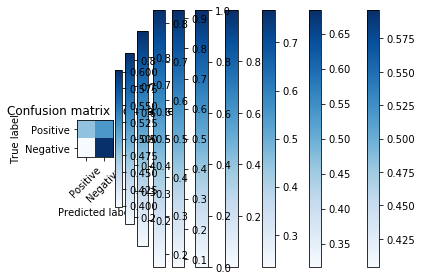

In [188]:
results_ngrams_tfidf = baseline_models(train_data_features, train_data['tag'],test_data_features, test_data['tag'])

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [133]:
most_influential_words(tf_vect, 0)

['acquisitions',
 'refinancing',
 'mw',
 'norcom',
 'charge',
 'goodwill',
 'technical',
 'debt',
 'despite',
 'trucks']

In [134]:
tf_vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function word_tokenize at 0x7f5d68490ae8>, use_idf=True,
        vocabulary=None)

### Things to try with bag of words

10 mins for exercises.

For more insight into the model print out the most influential words for a particular plot.

Try n-grams with TF-IDF.



# Averaging word vectors

Now let's use more complex features rather than just counting words.

A great recent achievement of NLP is the [word2vec embedding](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). See Chris Moody's [video](https://www.youtube.com/watch?v=vkfXBGnDplQ) for a great introduction to word2vec. 


First we load a word2vec model. It has been pre-trained by Google on a 100 billon word Google News corpus. You can play with this model using a fun [web-app](http://rare-technologies.com/word2vec-tutorial/#app).

Link to the web-app: http://rare-technologies.com/word2vec-tutorial/#app

Vocabulary size: 3 mln words. 

__Warning__: 3 mins to load, takes 4 GB of RAM.

In [135]:
%%time 
wv = gensim.models.KeyedVectors.load_word2vec_format(
    "/home/felix/Research/Files/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

2018-07-29 23:53:34,255 : INFO : loading projection weights from /home/felix/Research/Files/GoogleNews-vectors-negative300.bin.gz
2018-07-29 23:55:02,688 : INFO : loaded (3000000, 300) matrix from /home/felix/Research/Files/GoogleNews-vectors-negative300.bin.gz
2018-07-29 23:55:02,689 : INFO : precomputing L2-norms of word weight vectors


CPU times: user 1min 44s, sys: 2.13 s, total: 1min 47s
Wall time: 1min 48s


In [137]:
wv.layer1_size

AttributeError: 'KeyedVectors' object has no attribute 'layer1_size'

Example vocabulary

In [138]:
from itertools import islice
list(islice(wv.vocab, 13000, 13020))

['Alex_Lagesse',
 'Jon_Toigo',
 'Saintil',
 'Edsel_Mendoza',
 'CAIRN_ENERGY',
 'NITV',
 'By_Melvyn_Howe',
 'Beauchesne_rbeauchesne_@_seac',
 'WHAT_DO_YOU_EXPECT',
 '#.##ca',
 'Seger',
 'CSTV_AVCA_Division',
 'Zi_Teng',
 'Automechanika_Middle_East',
 'Andrew_Osidacz',
 'By_Mike_Corpos',
 'Kaminak_Gold_Corporation',
 'Rowalt',
 'multidomain_MDM',
 'Donaghys']

Now we have a vector for each word. How do we get a vector for a sequence of words (aka a document)?




The most naive way is just to take an average. [Mike Tamir](https://www.youtube.com/watch?v=7gTjYwiaJiU) has suggested that the resulting vector points to a single word summarising the whole document. For example all words in a book
 ‘A tale of two cities’ should add up to 'class-struggle’

<img src="images/naivedoc2vec.png">

In [139]:

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

For word2vec we apply a different tokenization. We want to preserve case as the vocabulary distingushes lower and upper case.

In [140]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [141]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['headline']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['headline']), axis=1).values

In [142]:
%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

CPU times: user 361 ms, sys: 8.05 ms, total: 369 ms
Wall time: 369 ms


Let's see how KNN and logistic regression classifiers perform on these word-averaging document features.

In [143]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.tag)


CPU times: user 28.9 ms, sys: 0 ns, total: 28.9 ms
Wall time: 27.4 ms


In [144]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

CPU times: user 1.68 s, sys: 583 ms, total: 2.26 s
Wall time: 518 ms


accuracy 0.5290240272166702
confusion matrix
 [[1004 1148]
 [1067 1484]]
(row=expected, col=predicted)


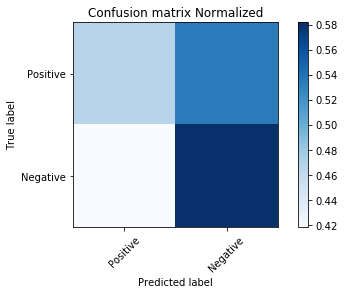

In [146]:
evaluate_prediction(predicted, test_data.tag)

KNN is even worse than the naive 'everything is comedy' baseline! Let's see if logistic regression is better.

accuracy 0.5371039761854136
confusion matrix
 [[ 847 1305]
 [ 872 1679]]
(row=expected, col=predicted)
CPU times: user 630 ms, sys: 339 ms, total: 969 ms
Wall time: 537 ms


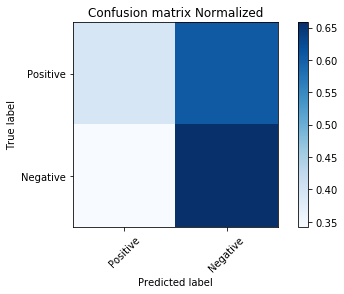

In [147]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['tag'])
predicted = logreg.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.tag)

Score without CV and l2 penalty: 0.5507123112906656
accuracy 0.5507123112906656
confusion matrix
 [[ 634 1518]
 [ 595 1956]]
(row=expected, col=predicted)
Score with CV: 0.5526259834148416
accuracy 0.5526259834148416
confusion matrix
 [[ 593 1559]
 [ 545 2006]]
(row=expected, col=predicted)
CPU times: user 7.69 s, sys: 5.22 s, total: 12.9 s
Wall time: 2.29 s


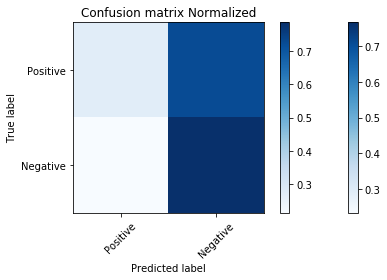

In [149]:
%%time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

def baseline_LogisticRegression(x_train,y_train,x_test,y_test,penalty='l2'):

    classifier = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty=penalty, random_state=None, tol=0.0001)
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    print('Score without CV and {} penalty: {}'.format(penalty, classifier.score(x_test, y_test)))
    evaluate_prediction(predicted, y_test)
    classifier_default = classifier
    #baseline_LogisticRegression(X_train_word_average, train_data['tag'],X_test_word_average,test_data.tag)
    classifier = LogisticRegressionCV(penalty='l2')
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)


    print('Score with CV: {}'.format(classifier.score(x_test, y_test)))
    evaluate_prediction(predicted, y_test)
    return {'classifier_default':classifier_default,'classifier_CV':classifier}

baseline_LogisticRegression(X_train_word_average, train_data['tag'],X_test_word_average,test_data.tag)

Nearest Neighbors accuracy: 0.530087178396768
accuracy 0.530087178396768
confusion matrix
 [[ 999 1153]
 [1057 1494]]
(row=expected, col=predicted)
Linear SVM accuracy: 0.5424197320859027
accuracy 0.5424197320859027
confusion matrix
 [[   0 2152]
 [   0 2551]]
(row=expected, col=predicted)
RBF SVM accuracy: 0.5634701254518393
accuracy 0.5634701254518393
confusion matrix
 [[ 802 1350]
 [ 703 1848]]
(row=expected, col=predicted)
Gaussian Process accuracy: 0.5585796300233893
accuracy 0.5585796300233893
confusion matrix
 [[ 512 1640]
 [ 436 2115]]
(row=expected, col=predicted)
Decision Tree accuracy: 0.5385923878375505
accuracy 0.5385923878375505
confusion matrix
 [[  99 2053]
 [ 117 2434]]
(row=expected, col=predicted)
Random Forest accuracy: 0.5449712949181373
accuracy 0.5449712949181373
confusion matrix
 [[ 154 1998]
 [ 142 2409]]
(row=expected, col=predicted)
Neural Net accuracy: 0.5426323623219221
accuracy 0.5426323623219221
confusion matrix
 [[   1 2151]
 [   0 2551]]
(row=expected, 

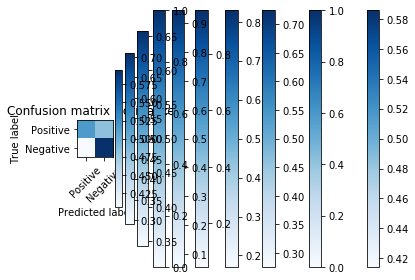

In [150]:
test = baseline_models(X_train_word_average, train_data['tag'],X_test_word_average,test_data.tag)

Nearest Neighbors accuracy: 0.535402934297257
accuracy 0.535402934297257
confusion matrix
 [[ 981 1171]
 [1014 1537]]
(row=expected, col=predicted)
Linear SVM accuracy: 0.549011269402509
accuracy 0.549011269402509
confusion matrix
 [[ 649 1503]
 [ 618 1933]]
(row=expected, col=predicted)
RBF SVM accuracy: 0.5634701254518393
accuracy 0.5634701254518393
confusion matrix
 [[ 802 1350]
 [ 703 1848]]
(row=expected, col=predicted)
Gaussian Process accuracy: 0.5585796300233893
accuracy 0.5585796300233893
confusion matrix
 [[ 512 1640]
 [ 436 2115]]
(row=expected, col=predicted)
Decision Tree accuracy: 0.5390176483095896
accuracy 0.5390176483095896
confusion matrix
 [[  99 2053]
 [ 115 2436]]
(row=expected, col=predicted)
Random Forest accuracy: 0.5485860089304699
accuracy 0.5485860089304699
confusion matrix
 [[ 197 1955]
 [ 168 2383]]
(row=expected, col=predicted)
Neural Net accuracy: 0.5424197320859027
accuracy 0.5424197320859027
confusion matrix
 [[   0 2152]
 [   0 2551]]
(row=expected, co

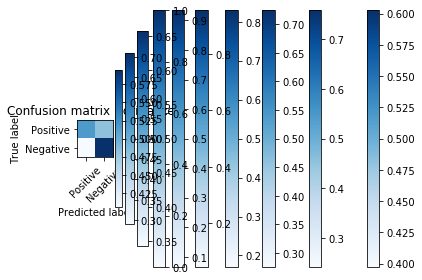

In [154]:
test2 = baseline_models(X_train_word_average, train_data['tag'],X_test_word_average,test_data.tag)

In [170]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def baseline_models(X_train,y_train,X_test,y_test):



    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes", "QDA","Gaussian Process",
             "Decision Tree"]

    classifiers = [
        KNeighborsClassifier(5),
        SVC(kernel="linear", C=1),
        SVC(gamma=2, C=1),

        RandomForestClassifier(max_depth=5, n_estimators=100, max_features='auto'),
        MLPClassifier(alpha=1),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier()]
    
    all_models = {}
    
    
    for name, clf in zip(names, classifiers):
        try:
            
            clf.fit(X_train, y_train)
            predicted = clf.predict(X_test)
            score = clf.score(X_test, y_test)
            all_models.update(name=clf)
            print("{} accuracy: {}".format(name,score))
            evaluate_prediction(predicted, y_test)
            
        except TypeError:
            clf.fit(X_train.toarray(),y_train)
            predicted = clf.predict(X_test.toarray())
            score = clf.score(X_test.toarray(), y_test)
            all_models.update(name=clf)
            print("{} accuracy: {}".format(name,score))
            evaluate_prediction(predicted, y_test)
        

    return all_models


In [136]:
all_models = {}
all_models.update(["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes", "QDA"])


ValueError: dictionary update sequence element #0 has length 17; 2 is required

Score without CV and l2 penalty: 0.5507123112906656
accuracy 0.5507123112906656
confusion matrix
 [[ 634 1518]
 [ 595 1956]]
(row=expected, col=predicted)
Score with CV: 0.5526259834148416
Done
accuracy 0.5526259834148416
confusion matrix
 [[ 593 1559]
 [ 545 2006]]
(row=expected, col=predicted)
CPU times: user 6.76 s, sys: 6.12 s, total: 12.9 s
Wall time: 1.91 s


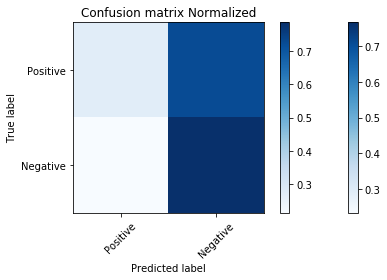

In [151]:
%%time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

classifier = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
classifier.fit(X_train_word_average, train_data['tag'])
predicted = classifier.predict(X_test_word_average)
print('Score without CV and l2 penalty: {}'.format(classifier.score(X_test_word_average, test_data.tag)))
evaluate_prediction(predicted, test_data.tag)

classifier = LogisticRegressionCV()
classifier.fit(X_train_word_average, train_data['tag'])
predicted = classifier.predict(X_test_word_average)

print('Score with CV: {}'.format(classifier.score(X_test_word_average, test_data.tag)))
print("Done")
evaluate_prediction(predicted, test_data.tag)

Great! It gives __54%__ accuracy. Best that we have seen so far.

accuracy 0.5526259834148416
confusion matrix
 [[ 593 1559]
 [ 545 2006]]
(row=expected, col=predicted)


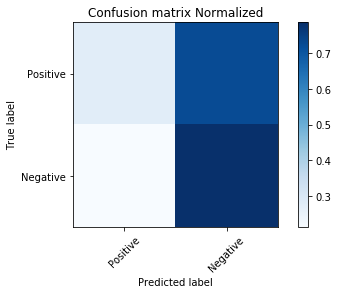

In [152]:
evaluate_prediction(predicted, test_data.tag)

Now just for fun let's see if text summarisation works on our data. Let's pick a plot and see which words it averages to.

In [330]:
test_data.iloc()[56]['headline']

'DEWB AG: Business Year 2004 Results'

Hmm... The summarisation doesn't work here. Any ideas why? Hint: look at the area where the average ends up.

In [331]:
wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

[('AG', 0.5456695556640625),
 ('Results', 0.5444972515106201),
 ('Business', 0.5440261363983154),
 ('First_Quarter_Results', 0.4970656633377075),
 ('Third_Quarter_Results', 0.4952167570590973),
 ('Full_Year', 0.4861656129360199),
 ('1st_Quarter', 0.4838767945766449),
 ('Second_Quarter_Results', 0.4797356128692627),
 ('Result', 0.4786844849586487),
 ('DGAP_News', 0.47245341539382935),
 ('Financial_Results', 0.47238242626190186),
 ('Profitability', 0.4698431193828583),
 ('c_Copyright_Thomson_Reuters', 0.46917134523391724),
 ('3rd_Quarter', 0.46823182702064514),
 ('Second_Quarter', 0.46802783012390137),
 ('First_Quarter', 0.4646504819393158),
 ('Third_Quarter', 0.4642823338508606),
 ('Year', 0.4636436998844147),
 ('Net_Profit', 0.4629511535167694),
 ('Earnings', 0.4533522129058838)]

### Word2vec things to try

10 mins exercise

Remove stop-words. 




In [332]:


def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            if word in stopwords.words('english'):
                continue
            tokens.append(word)
    return tokens

### What accuracy do you get?

In [333]:
### More word2vec things to try

#Experiment with other pre-trained models - see nice [list](https://github.com/3Top/word2vec-api/) from 3Top.


#Use Gensim's GloVe converter.


#Do IDF weighting in the averaging function.

# Doc2Vec

A [paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) by Google suggests a model for document classification called Paragraph Vectors Doc2Vec or Doc2vec in short. It is very similar to word2vec. 

It introduces 'a tag' - a word that is in every context in the document.

For our first try we tag every plot with its genre. This makes it 'semi-supervised' learning - the genre labels is just one objective among many.

In [334]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [335]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['headline']), tags=[r.tag]), axis=1)

In [336]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['headline']), tags=[r.tag]), axis=1)

This is what a training entry looks like - an example plot tagged by 'sci-fi'.

In [337]:
test_tagged.values[50]

TaggedDocument(words=['ixonos', 'sharpens', 'its', 'strategy'], tags=['Positive'])

In [338]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2017-12-01 16:59:21,770 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-12-01 16:59:21,771 : INFO : collecting all words and their counts
2017-12-01 16:59:21,773 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-12-01 16:59:21,804 : INFO : collected 7305 word types and 2 unique tags from a corpus of 7058 examples and 75153 words
2017-12-01 16:59:21,804 : INFO : Loading a fresh vocabulary
2017-12-01 16:59:21,808 : INFO : min_count=5 retains 1860 unique words (25% of original 7305, drops 5445)
2017-12-01 16:59:21,808 : INFO : min_count=5 leaves 66869 word corpus (88% of original 75153, drops 8284)
2017-12-01 16:59:21,811 : INFO : deleting the raw counts dictionary of 7305 items
2017-12-01 16:59:21,812 : INFO : sample=0.001 downsamples 55 most-common words
2017-12-01 16:59:21,812 : INFO : downsampling leaves estimated 50082 word corpus (74.9% of prior 66869)
2017-12-01 16:59:21,813 : INFO : estimated required memor

CPU times: user 3.95 s, sys: 8 ms, total: 3.96 s
Wall time: 3.94 s


Interesting thing about doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs of the next cell.

Consequently, the accuracy of logistic regression changes when the test set vectors change.

In [339]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 1.15 s, sys: 4 ms, total: 1.15 s
Wall time: 1.15 s


accuracy 0.543908143738
confusion matrix
 [[ 123 2029]
 [ 116 2435]]
(row=expected, col=predicted)


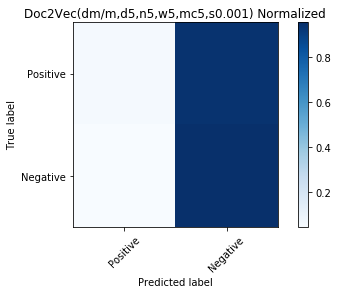

In [340]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

KNN gives a lower accuracy than logistic regression.

2017-12-01 16:59:38,142 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.49627897087
confusion matrix
 [[1233  919]
 [1450 1101]]
(row=expected, col=predicted)
CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 183 ms


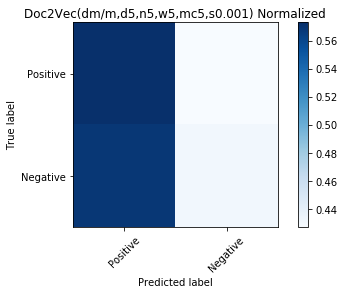

In [341]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Doc2vec gives us a vector for each genre so we can see which genres are close together.

In [342]:
doc2vec_model.docvecs.most_similar('Positive')

[('Negative', 0.9974029660224915)]

Words surrounding the 'sci-fi' tag describe it pretty accurately!

In [343]:
doc2vec_model.most_similar([doc2vec_model.docvecs['Positive']])

2017-12-01 16:59:51,601 : INFO : precomputing L2-norms of word weight vectors


[('patent', 0.9900999665260315),
 ('production', 0.9892203211784363),
 ('approval', 0.9876371026039124),
 ('orco', 0.9858270287513733),
 ('expansion', 0.9844255447387695),
 ('preparing', 0.9834451079368591),
 ('meditec', 0.9826142191886902),
 ('france', 0.9806460738182068),
 ('zeiss', 0.978387713432312),
 ('package', 0.9762388467788696)]

In [344]:
doc2vec_model.most_similar([doc2vec_model.docvecs['Negative']])

[('approval', 0.9950870275497437),
 ('production', 0.9924275875091553),
 ('expansion', 0.9887423515319824),
 ('preparing', 0.9876921772956848),
 ('orco', 0.9840092658996582),
 ('patent', 0.9813633561134338),
 ('its', 0.9780591726303101),
 ('subsidiaries', 0.976026177406311),
 ('ab', 0.9758869409561157),
 ('zeiss', 0.9735254645347595)]

### Doc2vec exercise

10 mins

Find the random seed that gives the best prediction. :)



accuracy 0.543695513502
confusion matrix
 [[ 115 2037]
 [ 109 2442]]
(row=expected, col=predicted)
20


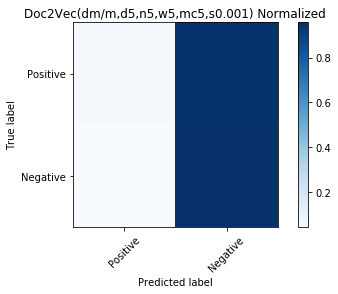

In [345]:
seed = 20

doc2vec_model.seed = seed
doc2vec_model.random = random.RandomState(seed)


test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])


logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, random_state=42)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))
print(doc2vec_model.seed)

## Doc2vec things to try
Try tagging every sentence with a unique tag 'SENT_123' and then apply KNN. 

Try multiple tags per plot as in this repo published __today__ : https://github.com/sindbach/doc2vec_pymongo



# Deep IR

'Deep IR' is a technique developed by  [“Document Classification by Inversion of Distributed Language Representations”, Matt Taddy](http://arxiv.org/pdf/1504.07295v3.pdf). Matt has contributed a gensim [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) - great source of more in depth information.

In short the algorithm is:

1. Train a word2vec model only on comedy plots.

2. Trian another model only on sci-fi, another on romance etc. Get 6 models - one for each genre.

3. Take a plot and see which model fits it best using Bayes' Theorem



The tokenization is different from other methods. The reason for this is that we are following an original approach in the paper. The purpose of this tutorial is to see how the models behave out of the box.

We just clean non-alphanumeric characters and split by sentences.

In [346]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")


In [347]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['tag'],\
        'x':[clean(s).split() for s in sentences(row['headline'])]}


In [348]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

CPU times: user 768 ms, sys: 4 ms, total: 772 ms
Wall time: 776 ms


In [349]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [350]:
def tag_sentences(reviews, stars=my_tags):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

An example `sci-fi` sentence:

In [353]:
next(tag_sentences(revtrain, my_tags[0]))

['silicon',
 'sensor',
 'international',
 'ag',
 'new',
 'chairmann',
 'new',
 'deputy',
 'chairmann',
 'of',
 'the',
 'supervisory',
 'board']

In [354]:
next(tag_sentences(revtrain, my_tags[1]))

['deutsche',
 'entertainment',
 'ag',
 'increase',
 'in',
 'profits',
 'in',
 'first',
 'quarter',
 'underlines',
 'expectations',
 'for',
 '2007']

We train our own 6 word2vec models from scratch. 

In [355]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
                     
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "genre (", len(slist), ")")
    genremodels[i].train(  slist, total_examples=len(slist),epochs=5, )
# get the probs (note we give docprob a list of lists of words, plus the models)


2017-12-01 17:01:55,151 : INFO : collecting all words and their counts
2017-12-01 17:01:55,152 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-01 17:01:55,173 : INFO : collected 6833 word types from a corpus of 76871 raw words and 9004 sentences
2017-12-01 17:01:55,174 : INFO : Loading a fresh vocabulary
2017-12-01 17:01:55,178 : INFO : min_count=5 retains 1911 unique words (27% of original 6833, drops 4922)
2017-12-01 17:01:55,179 : INFO : min_count=5 leaves 69185 word corpus (90% of original 76871, drops 7686)
2017-12-01 17:01:55,182 : INFO : deleting the raw counts dictionary of 6833 items
2017-12-01 17:01:55,183 : INFO : sample=0.001 downsamples 49 most-common words
2017-12-01 17:01:55,184 : INFO : downsampling leaves estimated 52646 word corpus (76.1% of prior 69185)
2017-12-01 17:01:55,184 : INFO : estimated required memory for 1911 words and 100 dimensions: 2866500 bytes
2017-12-01 17:01:55,186 : INFO : constructing a huffman tree from 1911 wor

Word2Vec(vocab=0, size=100, alpha=0.025)
Positive genre ( 4971 )


2017-12-01 17:01:55,351 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-12-01 17:01:55,352 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-12-01 17:01:55,352 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-12-01 17:01:55,353 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-12-01 17:01:55,353 : INFO : training on 209195 raw words (143810 effective words) took 0.1s, 1878688 effective words/s
2017-12-01 17:01:55,354 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2017-12-01 17:01:55,356 : INFO : training model with 8 workers on 1911 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2017-12-01 17:01:55,411 : INFO : worker thread finished; awaiting finish of 7 more threads
2017-12-01 17:01:55,414 : INFO : worker thread finished; awaiting finish of 6 more threads
2017-12-01 17:01:55,422 : INFO : worker thread finish

Negative genre ( 4033 )
CPU times: user 616 ms, sys: 4 ms, total: 620 ms
Wall time: 282 ms


Now we will compute most likely class for a plot using Bayes' Theorem formula.

<img src='images/deep_ir_bayes.png' width=600>

For any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences. This is all in the following handy wrapper. (from the original [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) by Matt Taddy.

In [356]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [357]:
%%time
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

2017-12-01 17:02:38,427 : INFO : scoring sentences with 8 workers on 1911 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2017-12-01 17:02:38,455 : INFO : reached end of input; waiting to finish 24 outstanding jobs
2017-12-01 17:02:38,466 : INFO : scoring 6053 sentences took 0.0s, 156123 sentences/s
2017-12-01 17:02:38,467 : INFO : scoring sentences with 8 workers on 1911 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2017-12-01 17:02:38,490 : INFO : reached end of input; waiting to finish 24 outstanding jobs
2017-12-01 17:02:38,502 : INFO : scoring 6053 sentences took 0.0s, 175194 sentences/s


CPU times: user 136 ms, sys: 8 ms, total: 144 ms
Wall time: 83 ms


/home/felix/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


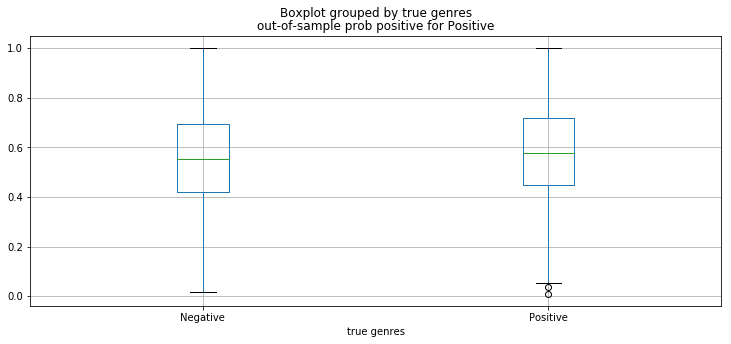

In [358]:
tag_index = 0
col_name = "out-of-sample prob positive for " + my_tags[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5))

In [359]:
target = [r['y'] for r in revtest]

accuracy 0.538592387838
confusion matrix
 [[ 836 1316]
 [ 854 1697]]
(row=expected, col=predicted)


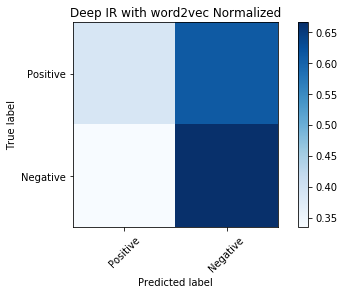

In [360]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")

Performance is worse than for a naive predictor that says that everything is `comedy`.

### Why?



It is because we train each word2vec model from scratch on a very small sample of about 30k words.

This model needs more data.

# Word Mover's Distance

<img src='images/wmd_gelato.png'>

Image from 
http://tech.opentable.com/2015/08/11/navigating-themes-in-restaurant-reviews-with-word-movers-distance/

Word Mover's Distance is a new algorithm developed in by [Matt Kusner](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf). There is Matt's code on [github](https://github.com/mkusner/wmd) and also Gensim can compute WMD similarity in this [PR](https://github.com/piskvorky/gensim/pull/659).

For KNN the best code is from [Vlad Niculae's blog](http://vene.ro/blog/word-movers-distance-in-python.html). He is a contributor to sklearn and did great integration of WMD with sklearn KNN.

__Warning__: Write 7 GB file on disk to use memory mapping.

## __This part requires Python 3__

In [361]:
ls

data/                                                        ipynb_with_output/
Document classification with word embeddings tutorial.ipynb  README.md
images/                                                      slides.pdf


In [363]:
%%time

data_folder = './data/'

fp = np.memmap(data_folder + "embed.dat", dtype=np.double, mode='w+', shape=wv.syn0norm.shape)
fp[:] = wv.syn0norm[:]

with smart_open(data_folder + "embed.vocab", "w") as f: 
    for _, w in sorted((voc.index, word) for word, voc in wv.vocab.items()):
        print(w.encode('utf8'), file=f)
del fp, wv

CPU times: user 8.54 s, sys: 4.52 s, total: 13.1 s
Wall time: 31 s


In [364]:
W = np.memmap(data_folder + "embed.dat", dtype=np.double, mode="r", shape=(3000000, 300))
with smart_open(data_folder + "embed.vocab", mode="rb") as f:
    vocab_list = [line.strip() for line in f]

In [365]:
vocab_dict = {w: k for k, w in enumerate(vocab_list)}

### sklearn KNN integration with WMD

In [366]:
"""%%file word_movers_knn.py"""

# Authors: Vlad Niculae, Matt Kusner
# License: Simplified BSD

import numpy as np
from sklearn.metrics import euclidean_distances
from sklearn.externals.joblib import Parallel, delayed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import check_array
from sklearn.cross_validation import check_cv
from sklearn.metrics.scorer import check_scoring
from sklearn.preprocessing import normalize

from pyemd import emd


class WordMoversKNN(KNeighborsClassifier):
    """K nearest neighbors classifier using the Word Mover's Distance.

    Parameters
    ----------
    
    W_embed : array, shape: (vocab_size, embed_size)
        Precomputed word embeddings between vocabulary items.
        Row indices should correspond to the columns in the bag-of-words input.

    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for :meth:`k_neighbors` queries.

    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run for Word Mover's Distance computation.
        If ``-1``, then the number of jobs is set to the number of CPU cores.
    
    verbose : int, optional
        Controls the verbosity; the higher, the more messages. Defaults to 0.
        
    References
    ----------
    
    Matt J. Kusner, Yu Sun, Nicholas I. Kolkin, Kilian Q. Weinberger
    From Word Embeddings To Document Distances
    The International Conference on Machine Learning (ICML), 2015
    http://mkusner.github.io/publications/WMD.pdf
    
    """
    _pairwise = False

    def __init__(self, W_embed, n_neighbors=1, n_jobs=1, verbose=False):
        self.W_embed = W_embed
        self.verbose = verbose
        super(WordMoversKNN, self).__init__(n_neighbors=n_neighbors, n_jobs=n_jobs,
                                            metric='precomputed', algorithm='brute')

    def _wmd(self, i, row, X_train):
        """Compute the WMD between training sample i and given test row.
        
        Assumes that `row` and train samples are sparse BOW vectors summing to 1.
        """
        union_idx = np.union1d(X_train[i].indices, row.indices)
        W_minimal = self.W_embed[union_idx]
        W_dist = euclidean_distances(W_minimal)
        bow_i = X_train[i, union_idx].A.ravel()
        bow_j = row[:, union_idx].A.ravel()
        return emd(bow_i, bow_j, W_dist)
    
    def _wmd_row(self, row, X_train):
        """Wrapper to compute the WMD of a row with all training samples.
        
        Assumes that `row` and train samples are sparse BOW vectors summing to 1.
        Useful for parallelization.
        """
        n_samples_train = X_train.shape[0]
        return [self._wmd(i, row, X_train) for i in range(n_samples_train)]

    def _pairwise_wmd(self, X_test, X_train=None):
        """Computes the word mover's distance between all train and test points.
        
        Parallelized over rows of X_test.
        
        Assumes that train and test samples are sparse BOW vectors summing to 1.
        
        Parameters
        ----------
        X_test: scipy.sparse matrix, shape: (n_test_samples, vocab_size)
            Test samples.
        
        X_train: scipy.sparse matrix, shape: (n_train_samples, vocab_size)
            Training samples. If `None`, uses the samples the estimator was fit with.
        
        Returns
        -------
        dist : array, shape: (n_test_samples, n_train_samples)
            Distances between all test samples and all train samples.
        
        """
        n_samples_test = X_test.shape[0]
        
        if X_train is None:
            X_train = self._fit_X

        dist = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
            delayed(self._wmd_row)(test_sample, X_train)
            for test_sample in X_test)

        return np.array(dist)

    def fit(self, X, y):
        """Fit the model using X as training data and y as target values

        Parameters
        ----------
        X : scipy sparse matrix, shape: (n_samples, n_features)
            Training data. 

        y : {array-like, sparse matrix}
            Target values of shape = [n_samples] or [n_samples, n_outputs]

        """
        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)
        return super(WordMoversKNN, self).fit(X, y)

    def predict(self, X):
        """Predict the class labels for the provided data
        Parameters
        ----------
        X : scipy.sparse matrix, shape (n_test_samples, vocab_size)
            Test samples.

        Returns
        -------
        y : array of shape [n_samples]
            Class labels for each data sample.
        """
        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)
        dist = self._pairwise_wmd(X)
        return super(WordMoversKNN, self).predict(dist)
    
    
class WordMoversKNNCV(WordMoversKNN):
    """Cross-validated KNN classifier using the Word Mover's Distance.

    Parameters
    ----------
    W_embed : array, shape: (vocab_size, embed_size)
        Precomputed word embeddings between vocabulary items.
        Row indices should correspond to the columns in the bag-of-words input.

    n_neighbors_try : sequence, optional
        List of ``n_neighbors`` values to try.
        If None, tries 1-5 neighbors.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, StratifiedKFold is used.

    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run for Word Mover's Distance computation.
        If ``-1``, then the number of jobs is set to the number of CPU cores.

    verbose : int, optional
        Controls the verbosity; the higher, the more messages. Defaults to 0.

    Attributes
    ----------
    cv_scores_ : array, shape (n_folds, len(n_neighbors_try))
        Test set scores for each fold.

    n_neighbors_ : int,
        The best `n_neighbors` value found.

    References
    ----------

    Matt J. Kusner, Yu Sun, Nicholas I. Kolkin, Kilian Q. Weinberger
    From Word Embeddings To Document Distances
    The International Conference on Machine Learning (ICML), 2015
    http://mkusner.github.io/publications/WMD.pdf
    
    """
    def __init__(self, W_embed, n_neighbors_try=None, scoring=None, cv=3,
                 n_jobs=1, verbose=False):
        self.cv = cv
        self.n_neighbors_try = n_neighbors_try
        self.scoring = scoring
        super(WordMoversKNNCV, self).__init__(W_embed,
                                              n_neighbors=None,
                                              n_jobs=n_jobs,
                                              verbose=verbose)

    def fit(self, X, y):
        """Fit KNN model by choosing the best `n_neighbors`.
        
        Parameters
        -----------
        X : scipy.sparse matrix, (n_samples, vocab_size)
            Data
        y : ndarray, shape (n_samples,) or (n_samples, n_targets)
            Target
        """
        if self.n_neighbors_try is None:
            n_neighbors_try = range(1, 6)
        else:
            n_neighbors_try = self.n_neighbors_try

        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)

        cv = check_cv(self.cv, X, y)
        knn = KNeighborsClassifier(metric='precomputed', algorithm='brute')
        scorer = check_scoring(knn, scoring=self.scoring)

        scores = []
        for train_ix, test_ix in cv:
            dist = self._pairwise_wmd(X[test_ix], X[train_ix])
            knn.fit(X[train_ix], y[train_ix])
            scores.append([
                scorer(knn.set_params(n_neighbors=k), dist, y[test_ix])
                for k in n_neighbors_try
            ])
        scores = np.array(scores)
        self.cv_scores_ = scores

        best_k_ix = np.argmax(np.mean(scores, axis=0))
        best_k = n_neighbors_try[best_k_ix]
        self.n_neighbors = self.n_neighbors_ = best_k

        return super(WordMoversKNNCV, self).fit(X, y)

Let's see how well it performs.

In [367]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['headline']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['headline']), axis=1).values

flat_train_tokenized = [item for sublist in train_tokenized for item in sublist]
flat_test_tokenized = [item for sublist in test_tokenized for item in sublist]

To speed up performance we focus only on the words that are both in Google News model and in our dataset.

In [368]:
# the word2vec model was loaded with strings as byte-arrays so need to convert
def convert_to_vocab_bytes(s):
     return bytes("b'" + s + "'", encoding='utf-8')    

In [375]:
vect = CountVectorizer(stop_words="english").fit(flat_train_tokenized)
common = [word for word in vect.get_feature_names() if convert_to_vocab_bytes(word) in vocab_dict]
W_common = W[[vocab_dict[convert_to_vocab_bytes(w)] for w in common]]

The mass of the pile of mud in the Word Mover's Distance is determined by how many times a word appears in a document. So we need a CountVectorizer.

In [376]:
train_tokenized[3]

['Supervisory',
 'Board',
 'GoYellow',
 'Media',
 'AG',
 'appoints',
 'new',
 'Management',
 'Board',
 'member']

In [377]:
vect = CountVectorizer(vocabulary=common, dtype=np.double,lowercase=False)
X_train = vect.fit_transform(train_tokenized)
X_test = vect.transform(test_tokenized)

TypeError: expected string or bytes-like object

In [377]:
%st
vect = CountVectorizer(vocabulary=common, dtype=np.double,lowercase=False)
X_train = vect.fit_transform(train_tokenized)
X_test = vect.transform(test_tokenized)

TypeError: expected string or bytes-like object

Let's train the model.

In [378]:
knn = WordMoversKNN(n_neighbors=1,W_embed=W_common, verbose=5, n_jobs=7)

In [379]:
knn.fit(X_train, train_data['tag'])

NameError: name 'X_train' is not defined

__Warning__: 10 minutes runtime on 7 cores

In [380]:
%%time 
predicted = knn.predict(X_test)

NameError: name 'X_test' is not defined

Only 2% above the naive baseline unfortunately. WMD achieves good results on sentiment analysis in the published paper. Maybe it works better for sentiment than for topic classification that we use it here. Or maybe preprocessing can be tuned here. It is hard to debug a black box method!

In [ ]:
evaluate_prediction(predicted, test_data['tag'])

# Conclusion

Above we shown how to run 'hello-world' in 7 different document classification techniques. It is just a beginning of exploration of their features... There are a lot of parameters that can be tuned to get the best possible results out of them. The 'hello-world' run is in no way an indication of their best peformance. The goal of this tutorial is to show the API so you can start tuning them yourself.

Out of the box "no tuning" accuracy of bag of words is not far behind more advanced techniques. 
Tune them and the pre-processing for them well first and only then reach for more advanced methods if more accuracy is absolutely needed.